In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from scipy.signal import find_peaks
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

plt.style.use('default')
cmap = 'jet'

arquivo = 'C:\\penelope\\KERNEL\\kernel 50\\3d-dose.dat'
Arq = np.loadtxt(arquivo)

i_max, j_max, k_max = map(int, np.max(Arq[:, 5:8], axis=0))
x_min, x_max = Arq[:, 0].min(), Arq[:, 0].max()
y_min, y_max = Arq[:, 1].min(), Arq[:, 1].max()
z_min, z_max = Arq[:, 2].min(), Arq[:, 2].max()

VoxelSize = [(x_max - x_min)/i_max, (y_max - y_min)/j_max, (z_max - z_min)/k_max]
EscalaX = np.linspace(x_min + VoxelSize[0]/2, x_max - VoxelSize[0]/2, i_max)
EscalaY = np.linspace(y_min + VoxelSize[1]/2, y_max - VoxelSize[1]/2, j_max)
EscalaZ = np.linspace(z_min + VoxelSize[2]/2, z_max - VoxelSize[2]/2, k_max)

Dose = np.zeros((i_max, j_max, k_max))
for linha in Arq:
    i, j, k = int(linha[5]) - 1, int(linha[6]) - 1, int(linha[7]) - 1
    Dose[i, j, k] = linha[3]
max_dose_original = np.max(Dose)


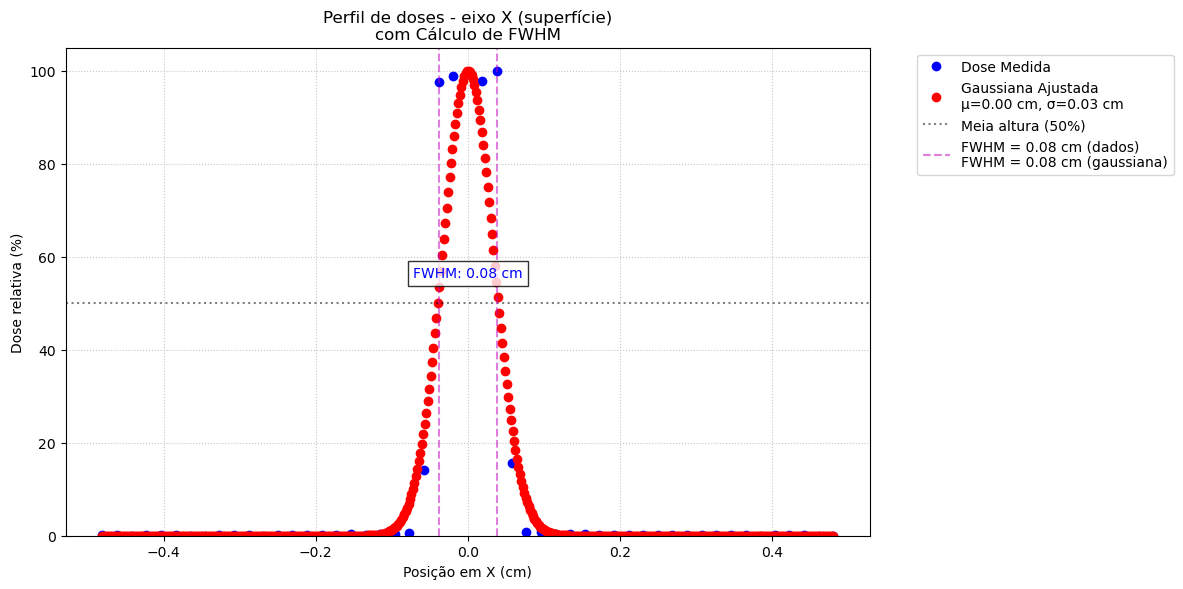


=== RESULTADOS DO AJUSTE ===
Amplitude: 100.00%
Posição do pico (μ): 0.00 cm
Desvio padrão (σ): 0.03 cm

=== LARGURA A MEIA ALTURA (FWHM) ===
FWHM calculado dos dados: 0.08 cm
FWHM teórico (2.355×σ): 0.08 cm
Diferença absoluta: 0.00 cm
Diferença relativa: 3.7%


In [4]:

def gaussian_limited(x, amplitude, mean, sigma):
    amplitude = min(amplitude, 100)
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))
#x-valores onde a função será calculada
#mean (μ)- posicao do centro do pico
#sigma - desvio padrão, largura da curva]

#  PERFIL DE DOSE EM X
Perfil = Dose[:, int(j_max/2), 0]
Max_perfil = np.max(Perfil)
Perfil_normalizado = 100 * Perfil / Max_perfil

#  AJUSTE GAUSSIANO 
pico_pos = np.argmax(Perfil_normalizado)
x_pico = EscalaX[pico_pos]
#encontra o pico do perfil normalizado
#array com a posicao em cm do pico

# Parâmetros iniciais sem offset
amplitude_guess = min(Perfil_normalizado[pico_pos], 100)  
mean_guess = x_pico
#sigma_guess = (EscalaX[-1] - EscalaX[0])/4
#define altura como 100% baseado no perfil de dose
#usa posicao do pico como o centro da gaussiana
#define o valor da largura da gaussiana como 1/4 do valor do eixo x

# Método 2: Diretamente dos dados da simulação
half_max = np.max(Perfil_normalizado)/2
    # Encontra todos os pontos acima da meia altura
above_half = np.where(Perfil_normalizado >= half_max)[0]
    # Pega o primeiro e último ponto acima da meia altura
left_idx, right_idx = above_half[0], above_half[-1]
fwhm_data = EscalaX[right_idx] - EscalaX[left_idx]
sigma_guess= fwhm_data/2.355

sigma_max= 0.1
bounds=([0, EscalaX[0], 0], [100, EscalaX[-1], sigma_max])
erros = np.ones_like(Perfil_normalizado)
erros[Perfil_normalizado < half_max] = 0.5  # Menor peso nas caudas
# Realizando o ajuste
try:
    popt, pcov = curve_fit(gaussian_limited, EscalaX, Perfil_normalizado, 
                          p0=[amplitude_guess, mean_guess, sigma_guess],
                          bounds=bounds, sigma=erros)
    #ajuste do perfil da gaussiana ao perfil de doses em x
    #p0 valores inciiais
    #bounds - limites dos parametros
    #popt - saida do parametro otimizado
    #pcov matriz de covariancia
    
    x_suavizado = np.linspace(EscalaX[0], EscalaX[-1], 500)
    y_suavizado = gaussian_limited(x_suavizado, *popt)
    ajuste_realizado = True
    #500 pontos da gaussiana ajustados ao longo de x

    # FWHM 
    fwhm_gaussian = 2.355 * abs(popt[2])
    
    
except RuntimeError:
    print("O ajuste gaussiano falhou - usando parâmetros iniciais")
    popt = [amplitude_guess, mean_guess, sigma_guess]
    ajuste_realizado = False

plt.figure(figsize=(12, 6))
plt.plot(EscalaX, Perfil_normalizado, 'bo', label='Dose Medida', linewidth=2)

if ajuste_realizado:
    # Curva ajustada
    plt.plot(x_suavizado, y_suavizado, 'ro', linewidth=2,
             label=f'Gaussiana Ajustada\nμ={popt[1]:.2f} cm, σ={abs(popt[2]):.2f} cm')
    
    # Linha da meia altura
    plt.axhline(y=half_max, color='k', linestyle=':', alpha=0.5, label='Meia altura (50%)')
    
    # Marcadores do FWHM
    plt.axvline(x=EscalaX[left_idx], color='m', linestyle='--', alpha=0.5)
    plt.axvline(x=EscalaX[right_idx], color='m', linestyle='--', alpha=0.5, 
                label=f'FWHM = {fwhm_data:.2f} cm (dados)\nFWHM = {fwhm_gaussian:.2f} cm (gaussiana)')
    
    # Texto com o valor do FWHM
    plt.text(popt[1], half_max+5, f'FWHM: {fwhm_data:.2f} cm', 
             ha='center', va='bottom', color='b', bbox=dict(facecolor='white', alpha=0.8))
    
    # Verifica se há pontos acima de 100%
    if np.any(y_suavizado > 100):
        print("Aviso: A curva ajustada ainda contém valores acima de 100%")
        print(f"Valor máximo ajustado: {np.max(y_suavizado):.2f}%")
        
plt.title('Perfil de doses - eixo X (superfície)\ncom Cálculo de FWHM')
plt.xlabel('Posição em X (cm)')
plt.ylabel('Dose relativa (%)')
plt.ylim(0, 105)  # Limite do eixo Y
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Legenda fora do gráfico
plt.tight_layout()
plt.show()


if ajuste_realizado:
    print("\n=== RESULTADOS DO AJUSTE ===")
    print(f"Amplitude: {popt[0]:.2f}%")
    print(f"Posição do pico (μ): {popt[1]:.2f} cm")
    print(f"Desvio padrão (σ): {abs(popt[2]):.2f} cm")
    print("\n=== LARGURA A MEIA ALTURA (FWHM) ===")
    print(f"FWHM calculado dos dados: {fwhm_data:.2f} cm")
    print(f"FWHM teórico (2.355×σ): {fwhm_gaussian:.2f} cm")
    print(f"Diferença absoluta: {abs(fwhm_data-fwhm_gaussian):.2f} cm")
    print(f"Diferença relativa: {abs(fwhm_data-fwhm_gaussian)/fwhm_data*100:.1f}%")

Parâmetros da Gaussiana Ajustada:
[['Amplitude' '99.99999999999999']
 ['Centro (μ)' '0.00033134139953091174']
 ['Sigma (σ)' '0.03387296051334296']
 ['FWHM' '0.07977082200892267']]

Distância entre picos para relação vale/pico de 15%: 0.15 cm


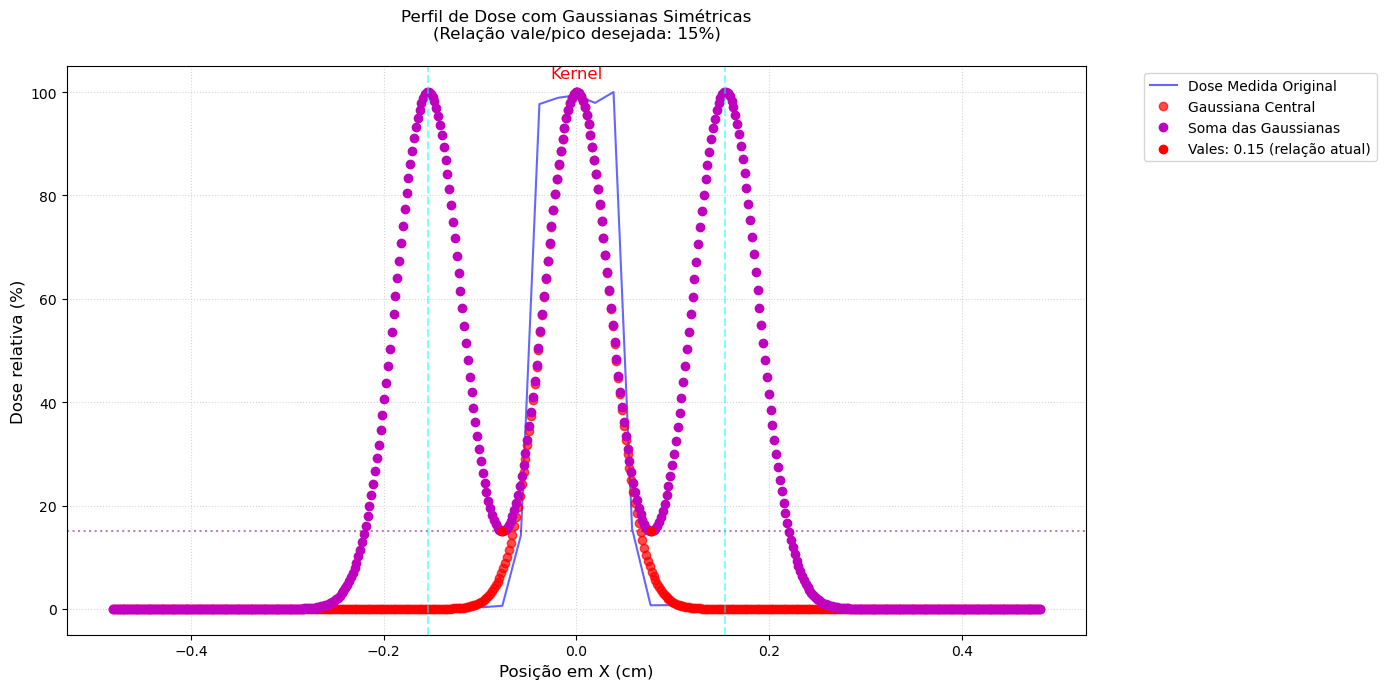


Dados salvos em 'gaussianas_simetricas.txt'


In [5]:
#Qual o fracionamento desejado?
relacao_vale_pico = 0.15

parametros_gaussiana = np.array([
    ['Amplitude', popt[0]],
    ['Centro (μ)', popt[1]],
    ['Sigma (σ)', popt[2]],
    ['FWHM', 2.355 * popt[2]]
]) #ajustes que foram obtidos no código anteriormente pelo fit gaussiano

print("Parâmetros da Gaussiana Ajustada:")
print(parametros_gaussiana)

#distancia entre o pico principal e outro pico
def encontrar_distancia(relacao_desejada, amplitude, sigma):
    #Calcula a distância necessária entre picos para atingir a relação vale/pico desejada
    def funcao_vale(d, a, s, r):
        valor_vale = 2 * a * np.exp(-(d/2)**2 / (2 * s**2)) # Dose no vale (soma de 2 gaussianas)
        return valor_vale - r * a # Diferença em relação ao valor desejado
    
    d_guess = 2 * sigma  #estimativa inicial
    distancia = bisect(funcao_vale, 0, 10*sigma, args=(amplitude, sigma, relacao_desejada))
    return distancia
#  usa a funcao bisect para encontrar a distância d que satisfaz valor_vale = relacao_desejada × amplitude.
# ========== CALCULAR A DISTÂNCIA NECESSÁRIA ==========
distancia_picos = encontrar_distancia(relacao_vale_pico, popt[0], popt[2])
print(f"\nDistância entre picos para relação vale/pico de {relacao_vale_pico:.0%}: {distancia_picos:.2f} cm")

# ========== CRIAR AS GAUSSIANAS SIMÉTRICAS ==========
def gaussianas_simetricas(x, amplitude, centro, sigma, distancia):
    """Cria 3 gaussianas: central, -X e +X"""
    gauss_central = gaussian_limited(x, amplitude, centro, sigma)
    gauss_negativa = gaussian_limited(x, amplitude, centro - distancia, sigma)
    gauss_positiva = gaussian_limited(x, amplitude, centro + distancia, sigma)
    return gauss_central, gauss_negativa, gauss_positiva

# Gerar as curvas
gauss_central, gauss_neg, gauss_pos = gaussianas_simetricas(
    x_suavizado, popt[0], popt[1], popt[2], distancia_picos
)

# Soma das gaussianas
gaussiana_total = gauss_central + gauss_neg + gauss_pos

# ========== PLOT DAS GAUSSIANAS SIMÉTRICAS ==========
plt.figure(figsize=(14, 7))

# Plot dos dados originais
plt.plot(EscalaX, Perfil_normalizado, 'b-', label='Dose Medida Original', linewidth=1.5, alpha=0.6)

if ajuste_realizado:
    # Plot das gaussianas individuais
    plt.plot(x_suavizado, gauss_central, 'ro', label='Gaussiana Central', linewidth=3, alpha=0.7)
    #plt.plot(x_suavizado, gauss_neg, 'g-', label=f'Gaussiana em -X ({-distancia_picos:.2f} cm)', linewidth=2, alpha=0.7)
    #plt.plot(x_suavizado, gauss_pos, 'g-', label=f'Gaussiana em +X ({distancia_picos:.2f} cm)', linewidth=2, alpha=0.7)
    plt.plot(x_suavizado, gaussiana_total, 'mo', label='Soma das Gaussianas', linewidth=3)
    
    # Calcular posição e valor do vale
    vale_pos_esq = popt[1] - distancia_picos/2
    vale_pos_dir = popt[1] + distancia_picos/2
    vale_valor = gaussian_limited(vale_pos_esq, popt[0], popt[1], popt[2]) * 2  # Duas gaussianas contribuem
    
    # Marcar os vales e picos
    plt.axhline(y=vale_valor, color='purple', linestyle=':', alpha=0.5)
    plt.axvline(x=popt[1] - distancia_picos, color='cyan', linestyle='--', alpha=0.5)
    plt.axvline(x=popt[1] + distancia_picos, color='cyan', linestyle='--', alpha=0.5)
    
    # Anotações
    plt.scatter([vale_pos_esq, vale_pos_dir], [vale_valor, vale_valor], color='red', zorder=5,
               label=f'Vales: {vale_valor/popt[0]:.2f} (relação atual)')
    plt.text(popt[1], popt[0]+5, 'Kernel', ha='center', va='top', fontsize=12, color='red')
    
plt.title(f'Perfil de Dose com Gaussianas Simétricas\n(Relação vale/pico desejada: {relacao_vale_pico:.0%})', pad=20)
plt.xlabel('Posição em X (cm)', fontsize=12)
plt.ylabel('Dose relativa (%)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# ========== SALVAR OS DADOS EM ARQUIVO ==========
dados_saida = np.column_stack((
    x_suavizado, 
    gauss_central, 
    gauss_neg, 
    gauss_pos, 
    gaussiana_total
))
np.savetxt('gaussianas_simetricas.txt', dados_saida, 
           header='PosX(cm) Gaussiana_Central(%) Gaussiana_-X(%) Gaussiana_+X(%) Soma(%)', 
           fmt='%.4f')
print("\nDados salvos em 'gaussianas_simetricas.txt'")